In [1]:
%cd ..

/home/paulw/projects/TRUSnet-1


In [95]:
import numpy as np 
import torch

def map_dict(func, dict): 
    return {
        k: func(v) for k, v in dict.items()
    }

def key_select(dict, *keys): 
    return {
        k: dict[k] for k in keys
    }

paths = {
    'train': 'train_latents.npz',
    'val': 'val_latents.npz', 
    'test': 'test_latents.npz'
}

FOLDER = 'latents/all_cores_core_classifier/'

paths = map_dict(
    lambda p: os.path.join(FOLDER, p), paths
)

latents_datasets = map_dict(
    lambda p: dict(np.load(p)), paths
)

def to_grade_group(gleason_score, primary_grade, secondary_grade): 
    
    if gleason_score == 'Benign': 
        return 0

    else: 
        return 1
    
    #gleason_score = {
    #    'GS7': 7, 
    #    'GS8': 8, 
    #    'GS9': 9, 
    #    'GS10': 10
    #}[gleason_score]
#
    #if gleason_score == 6: return 1
    #elif gleason_score == 7: 
    #    if primary_grade == 3: return 2
    #    else: return 3
    #elif gleason_score == 8: return 4 
    #elif gleason_score >= 9: return 5 
    #else: raise ValueError(f'Invalid grade encountered')


class LatentsDataset: 
    def __init__(self, latents_data): 
        self.latents_data = latents_data

    def __len__(self): 
        return len(self.latents_data['pool_output'])

    def __getitem__(self, idx):
        pool_output = self.latents_data['pool_output'][idx]
        pool_output = torch.tensor(pool_output)

        grade = self.latents_data['grade'][idx]
        primary_grade = self.latents_data['primary_grade'][idx]
        secondary_grade = self.latents_data['secondary_grade']
        grade_group = to_grade_group(grade, primary_grade, secondary_grade)
        grade_group = torch.tensor(grade_group)

        return pool_output, grade_group


BATCH_SIZE=64
def to_loader(dataset, train:bool): 
    from torch.utils.data import DataLoader
    return DataLoader(dataset, BATCH_SIZE, shuffle=train)

latents_datasets_torch = map_dict(LatentsDataset, latents_datasets)

train_loader = to_loader(latents_datasets_torch['train'], True)
val_loader = to_loader(latents_datasets_torch['val'], False)
test_loader = to_loader(latents_datasets_torch['test'], False)

In [99]:
latents_datasets['train']['pool_output'].shape

(4575, 512)

In [118]:
from umap import UMAP
m = UMAP(metric='yule', )
m.fit(latents_datasets['train']['pool_output'])

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


UMAP(metric='yule', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [119]:
feats = m.transform(latents_datasets['test']['pool_output'])

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


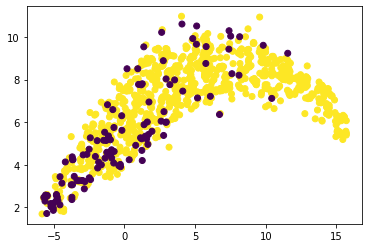

In [120]:
plt.scatter(feats[:, 0], feats[:, 1], c=latents_datasets['test']['grade'] == 'Benign')

In [149]:
from src.modeling.mlp import MLPClassifier

clf = MLPClassifier(512, 64, 16, num_classes=2, dropout=0.5)
#clf = torch.nn.Linear(512, 2)
clf.cuda()


Sequential(
  (0): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=512, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=16, bias=True)
    )
  )
  (1): Linear(in_features=16, out_features=2, bias=True)
)

In [154]:
from tqdm.notebook import tqdm
from src.utils.metrics import ClassificationOutputCollector
from torchmetrics.functional import accuracy
from contextlib import nullcontext

def shared_step(batch, model): 
    latents, grades = batch
    logits = model(latents.cuda())

    return {
        'grades': grades, 
        'logits': logits, 
    }

opt = torch.optim.Adam(clf.parameters(), lr=1e-5, weight_decay=1e-6)

def loss_func(logits, grades):
    logits = logits.cuda()
    grades = grades.cuda()
    weight = torch.tensor([1/0.92, 1/0.08])
    return torch.nn.functional.cross_entropy(logits, grades)

def epoch(loader, train):
    collector = ClassificationOutputCollector()
    for batch in loader: 
        with nullcontext() if train else torch.no_grad(): 
            out = shared_step(batch, clf)

        if train:
            loss = loss_func(out['logits'], out['grades'])
            loss.backward()
            opt.step()
            opt.zero_grad()

        collector.collect_batch(out)

    return collector.compute()


train_acc = []
val_acc = []

for _ in tqdm(range(1000)): 
    clf.train()
    out = epoch(train_loader, True)
    acc = accuracy(out['logits'], out['grades'], average='macro', num_classes=2)
    train_acc.append(acc)

    clf.eval()
    out = epoch(val_loader, False)
    acc = accuracy(out['logits'], out['grades'], average='macro', num_classes=2)
    val_acc.append(acc)


  0%|          | 0/1000 [00:00<?, ?it/s]

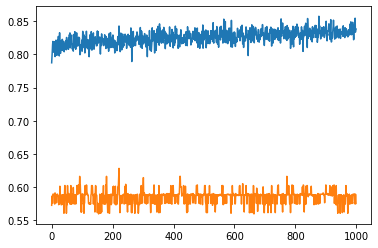

In [155]:
import matplotlib.pyplot as plt 
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')

In [ ]:
import mat

In [60]:
acc

tensor(0.2056)

In [35]:
train_loader

In [30]:
batch[1]

tensor([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

torch.Size([64])